In [15]:
from transformers import Pipeline, pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import os
import sys
from pathlib import Path
from tqdm import tqdm

class TopicSentimentAnalysis():
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-base", num_labels=3)
        checkpoint = torch.load("pytorch_model_10.bin")
        self.model.load_state_dict(checkpoint)
        self.tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")
        self.model.to(self.device)


    def piplines(self, text_list):
        ''''
        한 줄 요약에 대해 감성분석 진행
        input 
            test_list : List[string]    # 한 줄 요약
        output 
            result : List[string]   # 감성분석 결과(positive, neutral, negative)
        '''
        inputs = self.tokenizer(text_list, padding=True, truncation=True, return_tensors="pt").to(self.device)
        outputs = self.model(**inputs)
        predictions = outputs.logits @ torch.tensor([0, 2.5, 5.0]).to(self.device)
        result = predictions.detach().cpu().tolist()
        return result

    def sentiment_analysis(self, df):
        '''
        dataframe으로 들어온 데이터에 대해 감성분석을 진행하고 
        다시 dataframe으로 변환
        input
            df : pd.DataFrame()
        '''
        outputs = []
        for i in range(len(df['input'])//32+1):
            try:
                output = self.piplines(list(df['input'][32*i:32*(i+1)]))
            except:
                output = self.piplines(list(df['input'][32*i:]))
            outputs += output
        output = pd.DataFrame(outputs, columns=['score'])
        output = pd.concat([df, output], axis=1)
        return output

In [2]:
input_data = pd.read_pickle('하이닉스_input.pkl')

In [16]:
TSA = TopicSentimentAnalysis()    
output = TSA.sentiment_analysis(input_data)
output.to_csv("output_test.csv", index=False)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifie

In [18]:
output['score']

0         9.378292
1        15.273149
2        19.310915
3         6.904504
4       -17.096582
           ...    
30066   -17.809187
30067   -18.307804
30068   -18.366650
30069    18.309706
30070    18.731476
Name: score, Length: 30071, dtype: float64

In [19]:
import numpy as np

In [20]:
np.mean(output['score'])

2.7157732138268305

In [21]:
import seaborn as sns

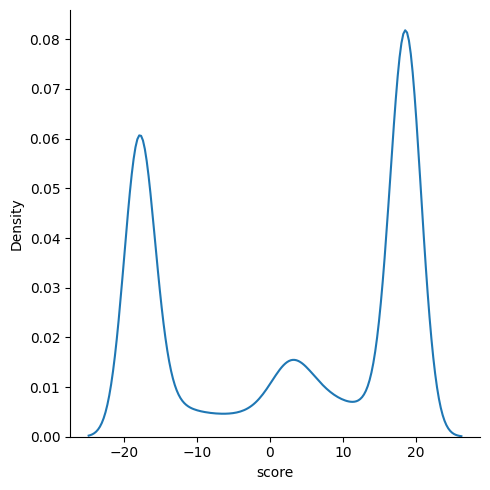

In [23]:
sns.displot(output, x="score", kind="kde")

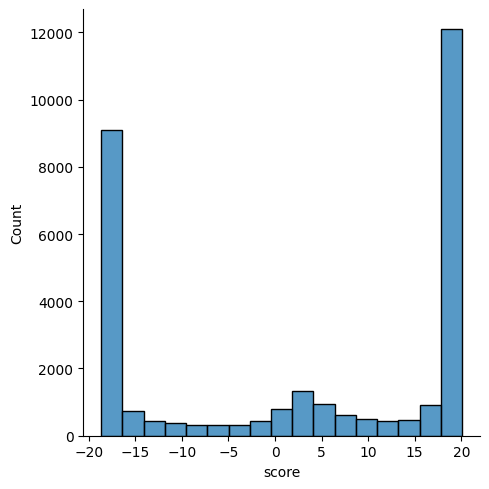

In [24]:
sns.displot(output, x="score")

In [32]:
score = pd.DataFrame(output.groupby('일자').mean()['score'])

/tmp/ipykernel_10163/1441836553.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score = pd.DataFrame(output.groupby('일자').mean()['score'])


In [60]:
score.index = pd.to_datetime(score.index, format='%Y%m%d')

In [28]:
from pykrx import stock
from pykrx import bond

In [29]:
df = stock.get_market_ohlcv("20150101", "20230220", "000660")

In [30]:
df

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2015-01-02,47950,48400,47650,47750,1155944,55452973972,0.00
2015-01-05,48050,48400,47500,47650,1409146,67511939450,-0.21
2015-01-06,47000,47600,46900,47500,1661196,78445189000,-0.31
2015-01-07,46700,47600,46700,47400,1821266,86042161150,-0.21
2015-01-08,48250,50000,47900,49950,5006675,247489413350,5.38
...,...,...,...,...,...,...,...
2023-02-14,91800,93500,91600,93400,2185525,202966243344,3.09
2023-02-15,93800,94200,91200,91700,1801577,165824028298,-1.82
2023-02-16,91900,93400,91600,92900,1812496,167987099000,1.31


In [68]:
concat_df = pd.concat([df, score], join='outer', axis=1)

In [69]:
concat_df

,시가,고가,저가,종가,거래량,거래대금,등락률,score
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.224844
2015-01-02,47950.0,48400.0,47650.0,47750.0,1155944.0,5.545297e+10,0.00,-18.058496
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.776773
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.014981
2015-01-05,48050.0,48400.0,47500.0,47650.0,1409146.0,6.751194e+10,-0.21,-0.351595
...,...,...,...,...,...,...,...,...
2023-02-16,91900.0,93400.0,91600.0,92900.0,1812496.0,1.679871e+11,1.31,13.294896
2023-02-17,91400.0,92700.0,90900.0,92000.0,1691509.0,1.555240e+11,-0.97,-8.109072
2023-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.267829
2023-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.260258


<AxesSubplot: xlabel='score', ylabel='Density'>

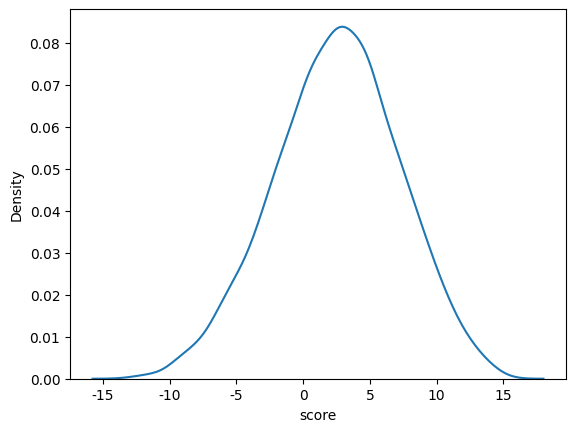

In [80]:
concat_df['window_7'] = concat_df['score'].rolling(window=7).mean()
sns.kdeplot(concat_df['score'].rolling(window=7).mean())

<AxesSubplot: xlabel='score', ylabel='Density'>

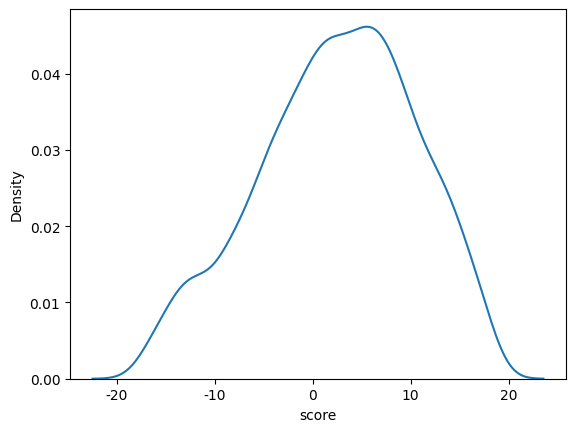

In [81]:
concat_df['ewm_8'] = concat_df['score'].ewm(alpha=0.8).mean()
sns.kdeplot(concat_df['score'].ewm(alpha=0.8).mean())

In [76]:
concat_df['score'].ewm(alpha=0.8).mean()

2015-01-01     6.224844
2015-01-02   -14.011272
2015-01-03    -9.789902
2015-01-04    -1.132143
2015-01-05    -0.507504
                ...    
2023-02-16    10.598203
2023-02-17    -4.367617
2023-02-18    -8.287787
2023-02-19     6.550649
2023-02-20     2.692186
Name: score, Length: 2751, dtype: float64

In [92]:
print(np.percentile(concat_df['window_7'].dropna(), 95))
print(np.percentile(concat_df['window_7'].dropna(), 5))

10.160401802391814
-5.539384712354398


In [91]:
print(np.percentile(concat_df['ewm_8'], 95))
print(np.percentile(concat_df['ewm_8'], 5))

14.873312539625548
-12.32586011033137


In [87]:
dropna_df = concat_df.dropna()

In [88]:
dropna_df

,시가,고가,저가,종가,거래량,거래대금,등락률,score,window_7,ewm_8
2015-01-07,46700.0,47600.0,46700.0,47400.0,1821266.0,8.604216e+10,-0.21,-0.946323,-4.479460,-2.451441
2015-01-08,48250.0,50000.0,47900.0,49950.0,5006675.0,2.474894e+11,5.38,12.443804,-3.591037,9.464785
2015-01-09,50700.0,51400.0,49700.0,49700.0,3313929.0,1.680722e+11,-0.50,13.204626,0.875123,12.456659
2015-01-12,50000.0,50500.0,49450.0,50300.0,1709997.0,8.566229e+10,1.21,19.084131,2.123085,12.867941
2015-01-13,48500.0,49650.0,48500.0,49000.0,3047952.0,1.494218e+11,-2.58,5.170324,2.911931,6.709847
...,...,...,...,...,...,...,...,...,...,...
2023-02-14,91800.0,93500.0,91600.0,93400.0,2185525.0,2.029662e+11,3.09,3.201487,-0.176389,2.725236
2023-02-15,93800.0,94200.0,91200.0,91700.0,1801577.0,1.658240e+11,-1.82,-0.917022,-1.634302,-0.188571
2023-02-16,91900.0,93400.0,91600.0,92900.0,1812496.0,1.679871e+11,1.31,13.294896,1.356993,10.598203
2023-02-17,91400.0,92700.0,90900.0,92000.0,1691509.0,1.555240e+11,-0.97,-8.109072,0.818757,-4.367617


In [117]:
sum(dropna_df['ewm_8'] > np.percentile(concat_df['ewm_8'], 99))

5

In [118]:
sum(dropna_df['ewm_8'] < np.percentile(concat_df['ewm_8'], 1))

2

In [108]:
i[1]

시가          9.270000e+04
고가          9.330000e+04
저가          9.070000e+04
종가          9.250000e+04
거래량         1.774617e+06
거래대금        1.637723e+11
등락률         5.400000e-01
score       1.727570e+00
window_7    1.455755e+00
ewm_8       2.692186e+00
Name: 2023-02-20 00:00:00, dtype: float64

In [120]:
flag = False
w = 100
ret = []
high_95 = np.percentile(concat_df['ewm_8'], 95)
low_5 = np.percentile(concat_df['ewm_8'], 5)

for i in dropna_df.iterrows():
    ap = (i[1]['고가'] + i[1]['저가']) / 2
    ewm = i[1]['ewm_8']    
    if ewm >= high_95 and not flag:
        bp = ap
        flag = True
    elif ewm <= low_5 and flag:
        w *= (ap/bp)
        flag = False
        
    if flag:
        ret.append(i[1]['등락률'])
        
print(w)

163.4326899708917


In [152]:
kk = [0 for _ in range(5)]
kk[1:3] = [3, 4]
kk

[0, 3, 4, 0, 0]

In [154]:
' '.join([str(i) for i in kk])

'0 3 4 0 0'

In [150]:
n_bucket, n_balls = map(int, input().split())
result = [0 for ]

for i in range(n_balls):
    s_i, e_i, n = map(int, input().split())
    result[s_i-1:e_i] = [n for _ in range((e_i-s_i+1))]
    
print(result)

 5 4
 1 2 3
 3 4 4
 1 4 1
 2 2 2


[1, 2, 1, 1, 0]


In [107]:
flag = False
w = 100
high_95 = np.percentile(concat_df['window_7'].dropna(), 95)
low_5 = np.percentile(concat_df['window_7'].dropna(), 5)

for i in dropna_df.iterrows():
    ap = (i[1]['고가'] + i[1]['저가']) / 2
    ma = i[1]['window_7']
    
    if ma >= high_95 and not flag:
        bp = ap
        flag = True
    elif ma <= low_5 and flag:
        w *= (ap/bp)
        flag = False
        
print(w)

148.85428438483612
